# Modelos Mixtos

En la libreta previa exploramos cómo realizar un análisis de varianza de medidas repetidas en el dataset de `sleepstudy`, y comentamos que este dataset es muy utilizado para ejemplificar el uso y ventajas de los modelos mixtos o jerárquicos.
 
## Librerías y datos

In [14]:
import pandas as pd
import scipy.stats as stats
import numpy as np
import seaborn as sns
import statsmodels.api as sm
# !pip install pingouin -q # quita este comentario si estás en colab
import pingouin as pg
dataset = sm.datasets.get_rdataset('sleepstudy', package='lme4')
print("Librerías importadas y datset descargado")

Librerías importadas y datset descargado


Exploremos qué información adicional nos da statsmodels sobre este dataset.

In [2]:
dataset.title

'Reaction times in a sleep deprivation study'

In [3]:
dataset.package

'lme4'

`.package` nos dice de qué paquete de R se tomó el dataset, en este caso LME4.
 
También podemos ver la documentación propia de R para este dataset.

In [4]:
print(dataset.__doc__)

.. container::

   .. container::

      ========== ===============
      sleepstudy R Documentation
      ========== ===============

      .. rubric:: Reaction times in a sleep deprivation study
         :name: reaction-times-in-a-sleep-deprivation-study

      .. rubric:: Description
         :name: description

      The average reaction time per day (in milliseconds) for subjects
      in a sleep deprivation study.

      Days 0-1 were adaptation and training (T1/T2), day 2 was baseline
      (B); sleep deprivation started after day 2.

      .. rubric:: Format
         :name: format

      A data frame with 180 observations on the following 3 variables.

      ``Reaction``
         Average reaction time (ms)

      ``Days``
         Number of days of sleep deprivation

      ``Subject``
         Subject number on which the observation was made.

      .. rubric:: Details
         :name: details

      These data are from the study described in Belenky et al. (2003),
      for the

### Datos
Para acceder a los datos utilizamos el atributo `data`.

In [9]:
data = dataset.data
data.head()

,Reaction,Days,Subject
0,249.5600,0,308
1,258.7047,1,308
2,250.8006,2,308
3,321.4398,3,308
4,356.8519,4,308


## Modelo
Modelaremos la relación entre los días de deprivación de sueño y el tiempo de reacción permitiendo una pendiente aleatoria para cada sujeto a lo largo del tiempo.

### Interceptos aleatorios

In [25]:
model1 = sm.MixedLM.from_formula(
    'Reaction ~ Days',
    data=data,
    groups='Subject', # intercepto aleatorio
)

result1 = model1.fit()
print(result1.summary())

          Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  Reaction 
No. Observations:  180      Method:              REML     
No. Groups:        18       Scale:               960.4568 
Min. group size:   10       Log-Likelihood:      -893.2325
Max. group size:   10       Converged:           Yes      
Mean group size:   10.0                                   
----------------------------------------------------------
             Coef.   Std.Err.   z    P>|z|  [0.025  0.975]
----------------------------------------------------------
Intercept    251.405    9.747 25.794 0.000 232.302 270.508
Days          10.467    0.804 13.015 0.000   8.891  12.044
Subject Var 1378.176   17.156                             



En este modelo estamos permitiendo que cada sujeto varíe su intercepto, es decir, ajustamos el modelo para el tiempo de reacción de cada sujeto al momento cero.

Si analizamos lo resultados, vemos que el intercepto es `251.405`, este es el promedio del tiempo de reacción de los sujetos antes de la deprivación de sueño, es decir al momento cero. El coeficiente de `Days` es `10.467` es decir, que en promedio, cada día de deprivación, aumentó el tiempo de reacción en 10 ms.

Observa que la varianza de cada sujeto es de 1378.176, la desviación estándar sería su raíz `37.123`.

En el output de `summary` puedes ver también un rubro de `scale` que se refiere a la varianza del error del modelo.

Este modelo, sin embargo, no considera que cada sujeto responde de forma diferente a la deprivación, algunos sujetos parecen aumentar más o menos su tiempo de reacción conforme pasan los días. Veamos la siguiente figura.

### Visualización

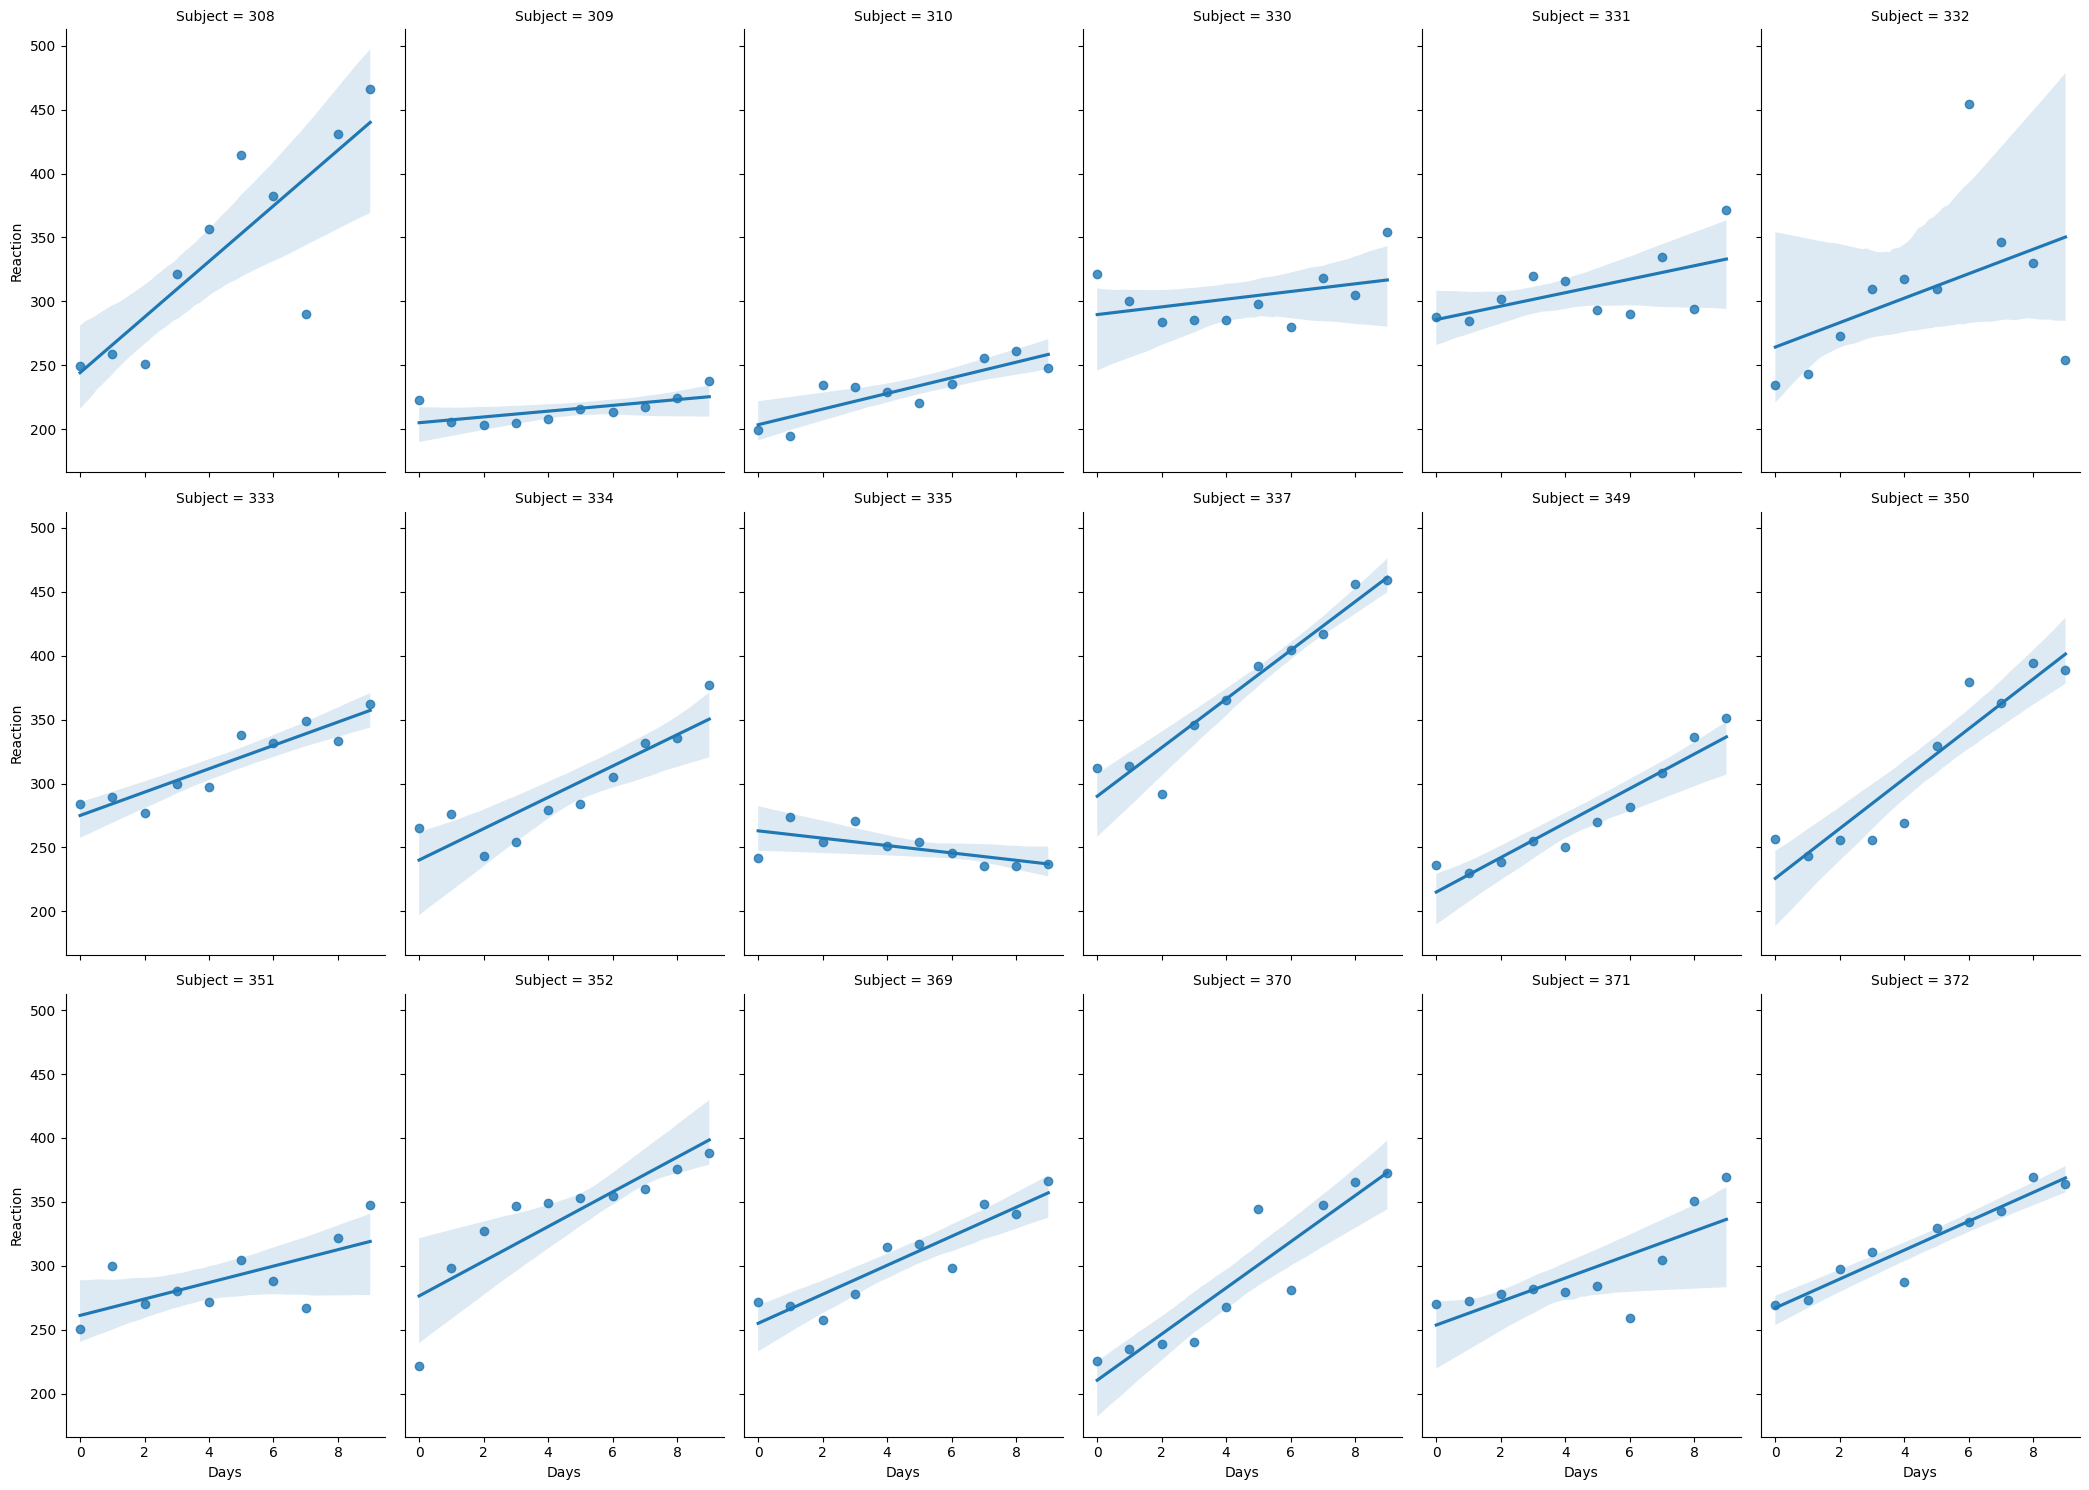

In [7]:
sns.lmplot(
    data,
    x='Days',
    y='Reaction',
    col='Subject',
    col_wrap=6,
    aspect=0.7,
)

### Pendiente aleatoria
Para poder contemplar la pendiente de cada sujeto en el modelo, debemos agregar una pendiente aleatoria, en statsmodels se ve así:

In [26]:
model2 = sm.MixedLM.from_formula(
    'Reaction ~ Days',
    data=data,
    groups='Subject', # intercepto aleatorio
    re_formula='~ Days', # pendiente aleatoria (Days|Subject)
)

result2 = model2.fit()
print(result2.summary())

             Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    Reaction 
No. Observations:    180        Method:                REML     
No. Groups:          18         Scale:                 654.9405 
Min. group size:     10         Log-Likelihood:        -871.8141
Max. group size:     10         Converged:             Yes      
Mean group size:     10.0                                       
----------------------------------------------------------------
                    Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
----------------------------------------------------------------
Intercept          251.405    6.825 36.838 0.000 238.029 264.781
Days                10.467    1.546  6.771 0.000   7.438  13.497
Subject Var        612.096   11.881                             
Subject x Days Cov   9.605    1.821                             
Days Var            35.072    0.610                             



Analicemos el resultado, en primer lugar destaca que disminuyó `scale` lo que quiere decir que el modelo tiene un error más pequeño y tenemos dos nuevos componentes en la matriz de varianzas-covarianzas: `Subject x Days Cov` y `Days Var`.

`Subject x Days Cov`: Es la covarianza del efecto de los días sobre cada sujeto. Es positiva, lo que nos indica que los sujetos que comienzan con más tiempo de reacción tienden a aumentar más su tiempo de reacción conforme pasan los días. Podemos incluso utilizar la fórmula de la correlación para convertir este valor en una forma más interpretable.

$$
\rho = \frac{COV(X, Y)}{\sqrt{VAR(X)} \cdot \sqrt{VAR(Y)}}
$$

Para resolverlo, ya tenemos la varianza del sujeto y la varianza de días, así que podemos utilizar el siguiente código:

In [27]:
result2.cov_re # matriz de covarianza

,Subject,Days
Subject,612.096487,9.604599
Days,9.604599,35.071623


In [28]:
cov = result2.cov_re.loc['Subject', 'Days']
var_subj = result2.cov_re.loc['Subject', 'Subject']
var_days = result2.cov_re.loc['Days', 'Days']
corr = cov / (np.sqrt(var_subj) * np.sqrt(var_days))
print(corr.round(3))

0.066


La correlación es pequeña, pero positiva. Una correlación cercana a cero indica que la variabilidad en el intercepto de los sujetos no está fuertemente relacionada con su sensibilidad al número de días de privación del sueño.

Este modelo contempla no solo el cambio del tiempo de reacción en el tiempo, sino que considera la variabilidad de cada sujeto.

## GEE

Los modelos de efectos mixtos  son poderosos, robustos y estables para analizar datos longitudinales, jerárquicos o agrupados y el resultado se enfoca en los individuos, pero si quisiéramos conocer el efecto poblacional de la deprivación del sueño, el modelo de elección serían las **Ecuaciones de estimación generalizadas** (GEE).

In [17]:
model3 = sm.GEE.from_formula(
    'Reaction ~ Days',
    data=data,
    groups='Subject'
)
result3 = model3.fit()
print(result3.summary())

                               GEE Regression Results                              
Dep. Variable:                    Reaction   No. Observations:                  180
Model:                                 GEE   No. clusters:                       18
Method:                        Generalized   Min. cluster size:                  10
                      Estimating Equations   Max. cluster size:                  10
Family:                           Gaussian   Mean cluster size:                10.0
Dependence structure:         Independence   Num. iterations:                     2
Date:                     Tue, 22 Jul 2025   Scale:                        2276.694
Covariance type:                    robust   Time:                         08:10:36
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    251.4051      6.632     37.906      0.000     238.406     264.404
Days   

A diferencia de los modelos mixtos, GEE no modela la variabilidad entre sujetos, sino que corrige la estimación de los efectos fijos teniendo en cuenta la correlación entre medidas repetidas. En el modelo 3 se usó la estructura de correlación independiente (por defecto), que no siempre es adecuada para datos longitudinales. Por eso, en el modelo 4 probamos una estructura `exchangeable`, que asume una correlación constante entre las observaciones de cada sujeto.

In [18]:
from statsmodels.genmod.cov_struct import Exchangeable

model4 = sm.GEE.from_formula(
    'Reaction ~ Days',
    data=data,
    groups='Subject',
    cov_struct=Exchangeable()
)
result4 = model4.fit()
print(result4.summary())

                               GEE Regression Results                              
Dep. Variable:                    Reaction   No. Observations:                  180
Model:                                 GEE   No. clusters:                       18
Method:                        Generalized   Min. cluster size:                  10
                      Estimating Equations   Max. cluster size:                  10
Family:                           Gaussian   Mean cluster size:                10.0
Dependence structure:         Exchangeable   Num. iterations:                     2
Date:                     Tue, 22 Jul 2025   Scale:                        2276.694
Covariance type:                    robust   Time:                         08:15:51
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    251.4051      6.632     37.906      0.000     238.406     264.404
Days   

En este caso, el resultado del modelo no cambia al modificar la estructura de correlación, ya que solo hay una observación por día por sujeto. Esto impide estimar de forma significativa la correlación entre medidas dentro de cada sujeto. Aun así, es buena práctica especificar una estructura de covarianza apropiada cuando se trabaja con datos longitudinales.

## Ejercicio
1. Aplica lo aprendido en con tus propios datos.
2. Busca el dataset `pbc` de `survival`. Lee su documentación y analízalo con las herramientas que aprendiste.